In [1]:
import functools
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets, transforms
from matplotlib import pyplot

In [2]:
# Code taken from https://github.com/pytorch/examples/blob/master/mnist/main.py

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    
class Logistic(nn.Module):
    def __init__(self):
        super(Logistic, self).__init__()
        self.linear = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = self.linear(x.view(x.size(0), -1))
        return F.log_softmax(x, dim=1)

In [3]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return {
        "loss": test_loss, "correct": correct / len(test_loader.dataset)}

In [4]:
def cache(dataset):
    loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=64, num_workers=20)
    cached = []
    for data, target in loader:
        for a, b in zip(data, target):
            cached.append([a.clone(), b.clone()])
    return cached
mnist_factory = functools.partial(datasets.MNIST, '../data', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])) 
cached_train_mnist = cache(mnist_factory(train=True))
cached_test_mnist = cache(mnist_factory(train=False))

In [29]:
def run(optimizer_factory, epochs=20, cuda=True, batch_size=64, eval_batch_size=512, model_factory=Net, scheduler_factory=None):
    device = torch.device("cuda" if cuda else "cpu")
    train_loader = torch.utils.data.DataLoader(
       cached_train_mnist, shuffle=True, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(
        cached_test_mnist, batch_size=eval_batch_size)

    model = model_factory().to(device)
    optimizer = optimizer_factory(model.parameters())
    corrects = []
    train_losses = []
    test_losses = []
    scheduler = scheduler_factory(optimizer) if scheduler_factory else None
    for epoch in range(epochs):
        if scheduler is not None:
            scheduler.step()
        train_losses.append(train(model, device, train_loader, optimizer, epoch))
        test_results = test(model, device, test_loader)
        test_losses.append(test_results['loss'])
        corrects.append(test_results['correct'])
    return train_losses, test_losses, corrects


In [6]:
results = {}

In [7]:
params = [
    ("sgd lr=0.01", {"lr": 0.01}),
    ("sgd lr=0.1", {"lr": 0.1}),
    ("sgd lr=0.001", {"lr": 0.001}),
    ("sgd lr=0.01 m=0.9", {"lr": 0.01, "momentum":0.9}),
]
for name, kwargs in params:
    print("Training {}".format(name))
    results[name] = run(functools.partial(optim.SGD, **kwargs))

Training sgd lr=0.01
Training sgd lr=0.1
Training sgd lr=0.001
Training sgd lr=0.01 m=0.9


In [23]:
for batch_size in [16, 32, 64, 128, 256, 512, 1024]:
    print("Doing batch size {}".format(batch_size))
    results["sgd bs={}".format(batch_size)] = run(functools.partial(optim.SGD, lr=0.01, momentum=0.9), batch_size=batch_size)

Doing batch size 16
Doing batch size 32
Doing batch size 64
Doing batch size 128
Doing batch size 256
Doing batch size 512
Doing batch size 1024


In [36]:
optimizer_factory = functools.partial(optim.SGD, lr=0.01, momentum=0.9)
scheduler_factory = functools.partial(optim.lr_scheduler.StepLR, step_size=10, gamma=0.5)
results["sgd schedule"] = run(optimizer_factory=optimizer_factory, scheduler_factory=scheduler_factory)

In [9]:
params = [
    ("gd lr=0.01", {"lr": 0.01}),
    ("gd lr=0.1", {"lr": 0.1}),
    ("gd lr=0.001", {"lr": 0.001}),
    ("gd lr=0.01 m=0.9", {"lr": 0.01, "momentum":0.9}),
]
for name, kwargs in params:
    print("Training {}".format(name))
    results[name] = run(functools.partial(optim.SGD, **kwargs), batch_size=len(cached_train_mnist))

Training gd lr=0.01
Training gd lr=0.1
Training gd lr=0.001
Training gd lr=0.01 m=0.9


In [10]:
params = [
    ("adagrad lr=0.01", {"lr": 0.01}),
    ("adagrad lr=0.1", {"lr": 0.1}),
    ("adagrad lr=0.001", {"lr": 0.001}),
]
for name, kwargs in params:
    print("Training {}".format(name))
    results[name] = run(functools.partial(optim.Adagrad, **kwargs))

Training adagrad lr=0.01
Training adagrad lr=0.1
Training adagrad lr=0.001


In [11]:
params = [
    ("adam lr=0.001", {"lr": 0.001}),
    ("adam lr=0.01", {"lr": 0.01}),
    ("adam lr=0.0001", {"lr": 0.0001}),
]

for name, kwargs in params:
    print("Training {}".format(name))
    results[name] = run(functools.partial(optim.Adam, **kwargs))

Training adam lr=0.001
Training adam lr=0.01
Training adam lr=0.0001


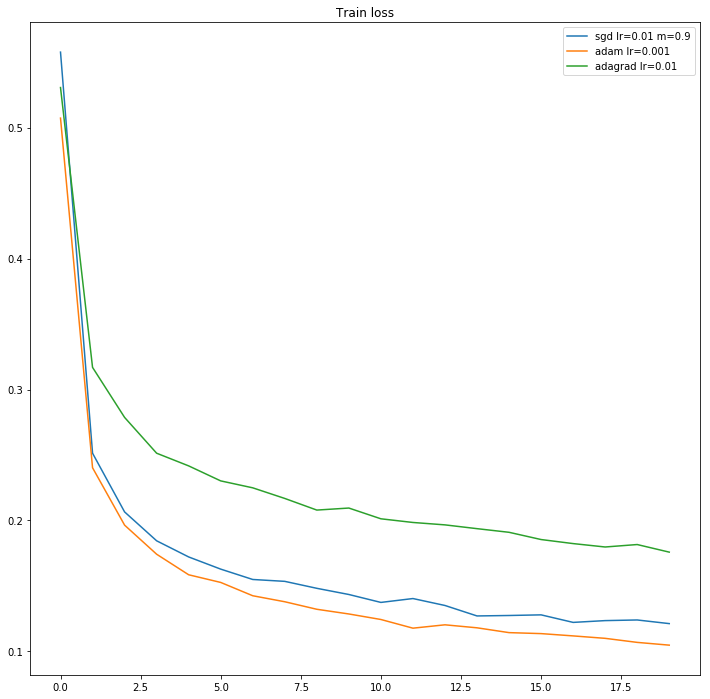

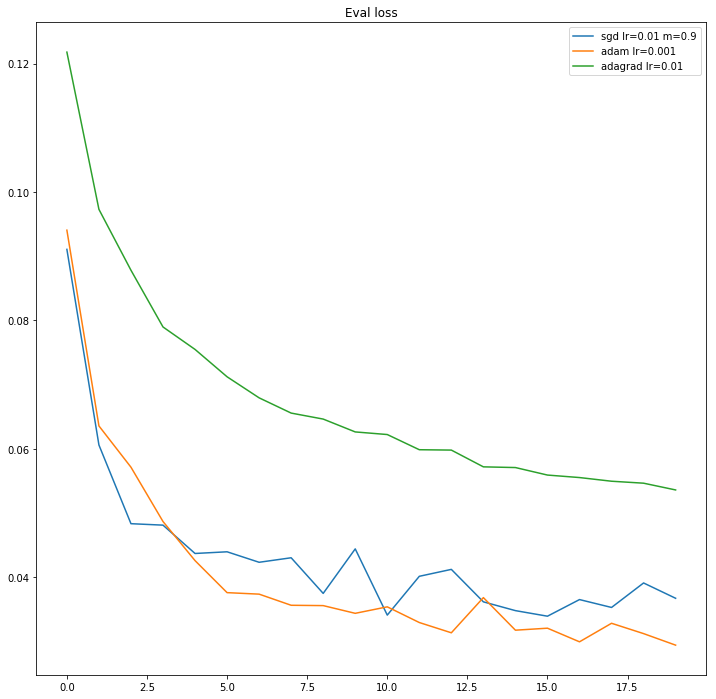

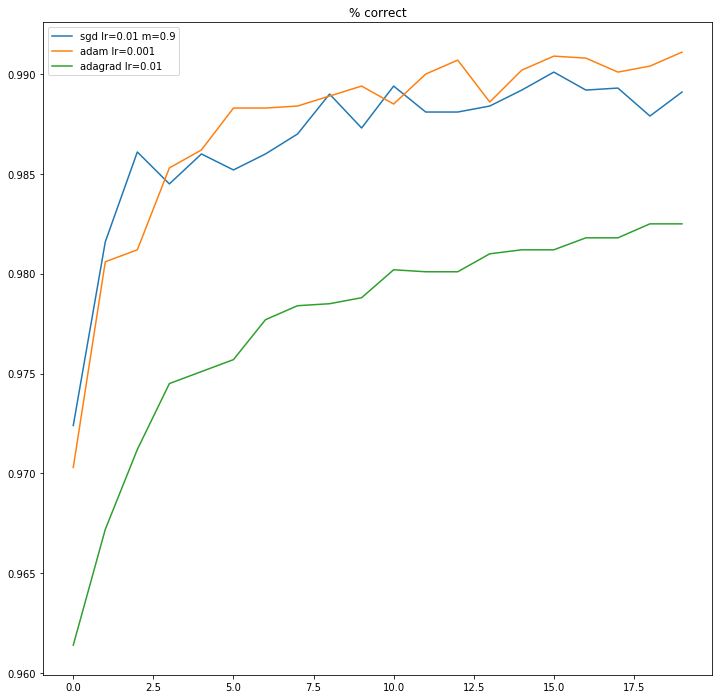

In [26]:
to_plot = [
     "sgd lr=0.01 m=0.9",
     "adam lr=0.001",
    "adagrad lr=0.01",
]
#to_plot = [name for name in results.keys() if "sgd" in name and "bs=" not in name]
#to_plot += [name for name in results.keys() if "adam" in name]

for idx, title in enumerate(["Train loss", "Eval loss", "% correct"]):
    pyplot.figure(figsize=(12, 12))
    pyplot.title(title)
    for name in to_plot:
        pyplot.plot(results[name][idx], label=name)
    pyplot.legend()

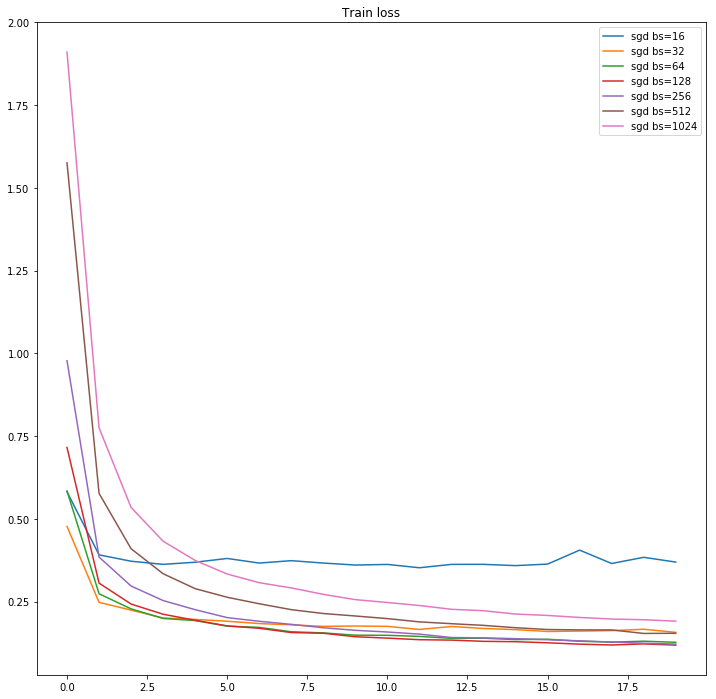

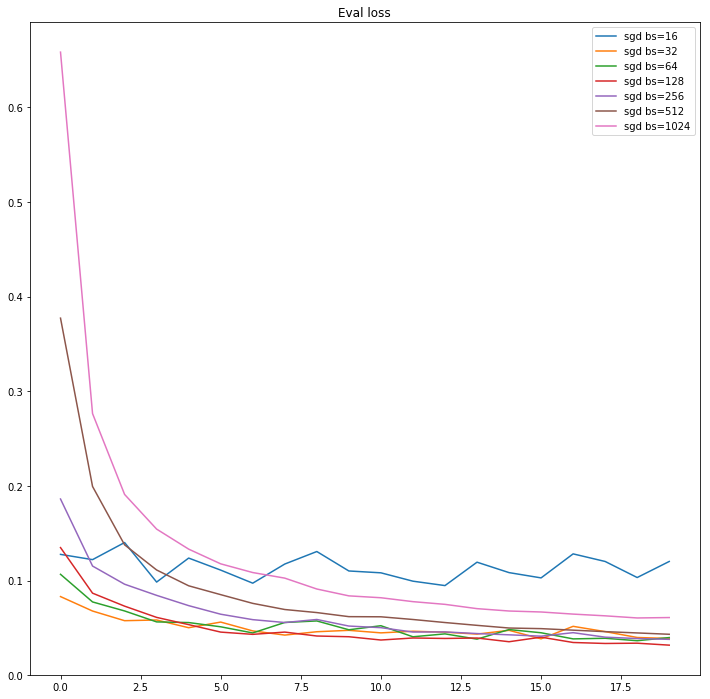

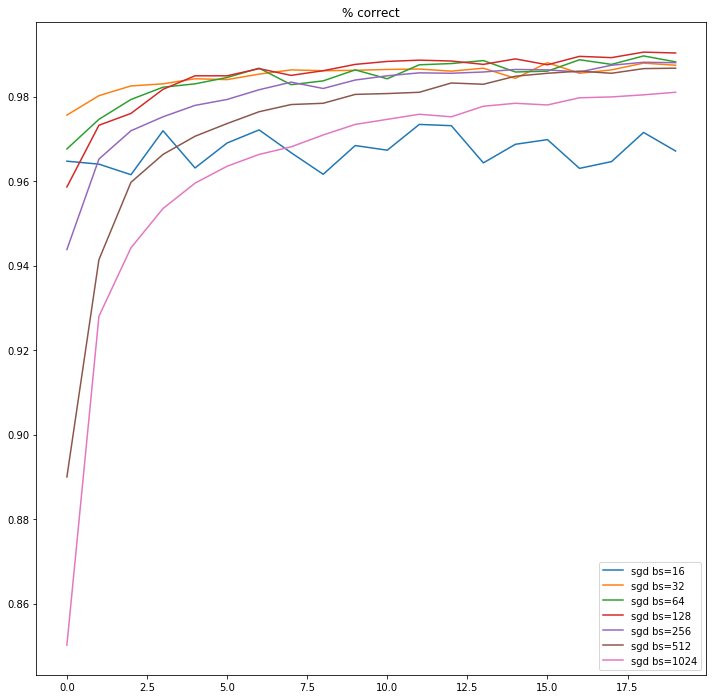

In [27]:
to_plot = [name for name in results.keys() if "bs=" in name]
for idx, title in enumerate(["Train loss", "Eval loss", "% correct"]):
    pyplot.figure(figsize=(12, 12))
    pyplot.title(title)
    for name in to_plot:
        pyplot.plot(results[name][idx], label=name)
    pyplot.legend()

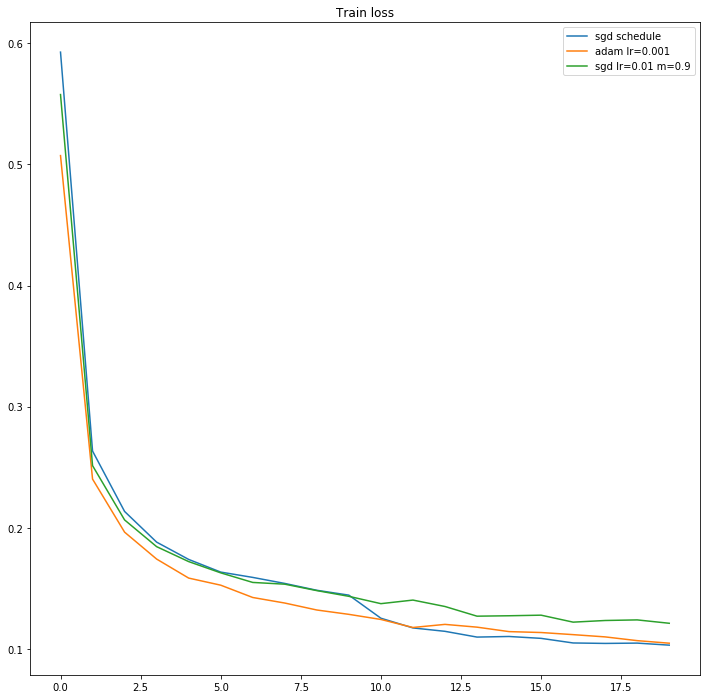

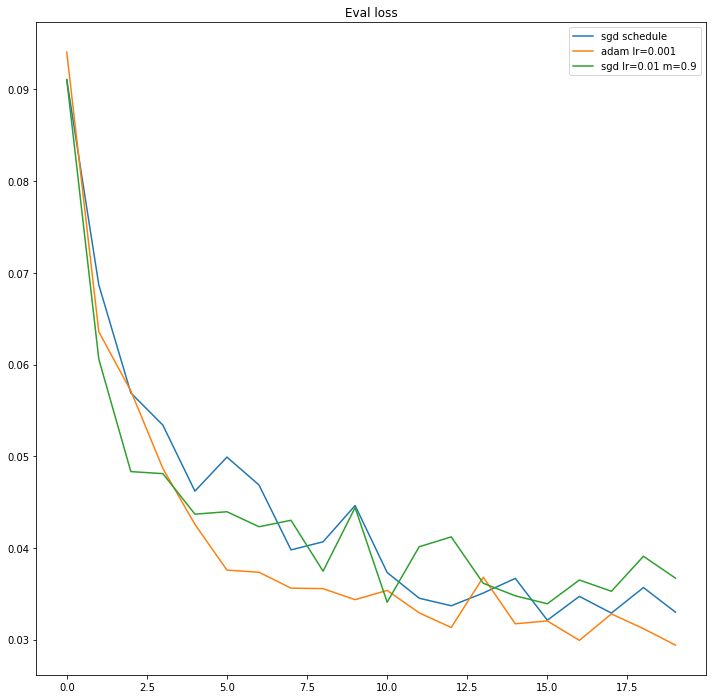

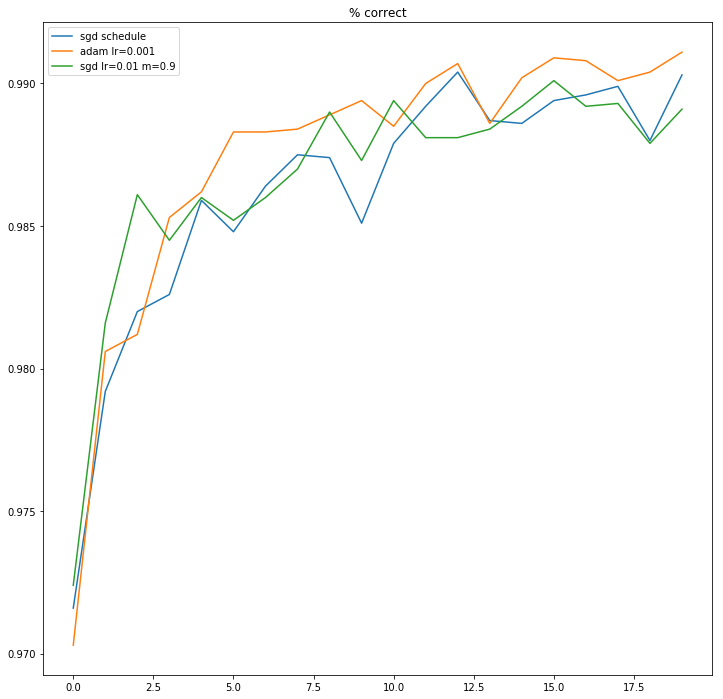

In [37]:
to_plot = [name for name in results.keys() if "schedule" in name]
to_plot += ["adam lr=0.001", "sgd lr=0.01 m=0.9"]
for idx, title in enumerate(["Train loss", "Eval loss", "% correct"]):
    pyplot.figure(figsize=(12, 12))
    pyplot.title(title)
    for name in to_plot:
        pyplot.plot(results[name][idx], label=name)
    pyplot.legend()